# Tarefa: Treinar uma GAN com o conjunto *Two Moons* do scikit-learn

Utilize o código acima como base e adapte-o para o seguinte problema:

1. Gere o conjunto de dados *Two Moons* utilizando a função `make_moons` do [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html):

```python
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=4096, noise=0.1, random_state=42)
```

Obs.: lembre-se de normalizar os dados.

2. Substitua os dados de treinamento originais do código pelo conjunto *Two Moons*.  
3. Treine uma GAN (com gerador e discriminador definidos no código) para aprender a distribuição do *Two Moons* (se necessário faça mudanças nas arquiteturas das redes neurais). **Não utilize parada antecipada: treine a GAN por 1000 épocas.**
4. Registre a evolução das perdas do gerador e do discriminador ao longo do treinamento.  
5. Gere gráficos comparando os dados reais (*Two Moons*) e as amostras criadas pelo gerador em diferentes épocas.  
6. Salve o modelo treinado e mostre como carregar e gerar novas amostras a partir dele.  

**Entregáveis:**  
1. Notebook .ipynb contendo:  
- O código adaptado e comentado.  
2. Relatório em .pdf
- Gráficos que mostrem o processo de treinamento.  
- Uma breve discussão sobre o treinamento e arquitetura da GAN, bem como sobre os resultados obtidos.

# Setup

In [1]:
!pip install torchinfo

In [2]:
import torch                                # Importa a biblioteca principal do PyTorch, usada para computação com tensores
from torch import nn                        # Importa o módulo 'nn' do PyTorch, utilizado para criar e treinar redes neurais
from torch.utils.data import DataLoader     # Importa o DataLoader do PyTorch, que facilita o carregamento de dados em mini-lotes (batches).
from torchvision import datasets            # Importa o módulo de conjuntos de dados do torchvision, que fornece acesso a conjuntos de dados populares como MNIST, CIFAR, etc. para visão computacional
from torchvision.transforms import ToTensor # Importa a transformação ToTensor, que converte imagens PIL ou NumPy arrays em tensores PyTorch
from torchinfo import summary               # Importa a função summary da biblioteca torchinfo, usada para exibir a arquitetura do modelo
import matplotlib.pyplot as plt             # Importa o módulo de visualização matplotlib para gerar gráficos.
import os                                   # Importa o módulo padrão do Python para interagir com o sistema operacional (ex.: criar pastas, manipular caminhos de arquivos).
import random

In [3]:
# Para figuras geradas pelo matplotlib serem exibidas diretamente no notebook
%matplotlib inline
torch.manual_seed(0)

# Preparando Conjunto de dados

In [5]:
from sklearn.datasets import make_moons
full_distribution = make_moons(n_samples=4096, noise=0.1, random_state=42)

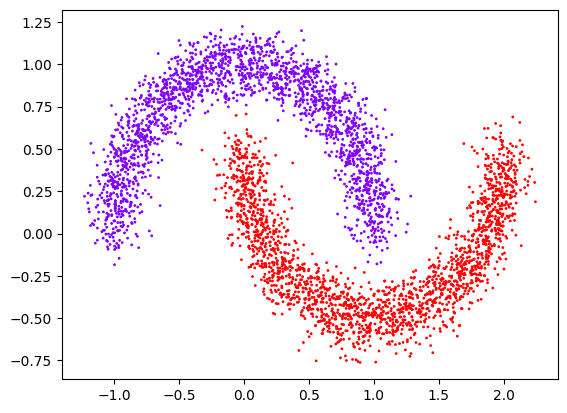

In [16]:
plt.scatter(full_distribution[0][:,0], full_distribution[0][:,1], s=1, c=full_distribution[1], cmap='rainbow')

In [17]:
print(type(full_distribution[0][0][0]))

<class 'numpy.float64'>


In [48]:
batch_size = 128                                 # Define o tamanho de cada mini-lote (quantidade de amostras processadas por iteração).
distribution = full_distribution[0]

# Normalização min max
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# train_data = scaler.fit_transform(distribution)
# train_data = torch.from_numpy(train_data).float() # Carrega dados como tensor e converte tipos

# Normalização x-media/std
train_data = torch.from_numpy(distribution).float()
mean = torch.mean(train_data, dim=0)
std = torch.std(train_data, dim=0)
train_data = (train_data - mean) / std # Normalização

train_loader = DataLoader(                       # Cria o objeto DataLoader para organizar os dados de treinamento.
    train_data,                                  # Conjunto de dados a ser usado (nosso tensor com pares (x, y)).
    batch_size = batch_size,                     # Número de amostras por lote = 128.
    shuffle = True)                              # Embaralha os dados a cada época.

In [49]:
batch0 = next(iter(train_loader))                # Cria um iterador sobre o DataLoader e obtém o primeiro mini-lote de dados (128 amostras).
print(batch0)                                    # Exibe no console o conteúdo desse mini-lote (tensor com shape [128, 2]).

tensor([[ 0.9387, -1.6619],
        [-0.0279,  1.4222],
        [ 0.2143,  0.6975],
        [ 0.0767, -1.0011],
        [ 0.5832, -0.0189],
        [ 1.2378, -1.2371],
        [ 0.4628,  0.3441],
        [-0.5561, -0.0455],
        [ 0.3001, -1.6594],
        [-0.0022, -1.1825],
        [-1.0657,  1.1750],
        [ 0.4463, -1.4590],
        [ 0.1300, -0.9852],
        [-1.1404,  1.2024],
        [-1.5430,  0.8247],
        [ 1.2073, -1.5716],
        [ 1.3977, -0.7178],
        [-0.3890, -0.4307],
        [-1.4095, -0.4630],
        [-0.9998,  1.6052],
        [-1.6767, -0.7837],
        [ 0.4488,  0.5764],
        [ 1.8080,  0.1066],
        [-1.5089,  0.6519],
        [ 0.3223, -1.3063],
        [-0.6575,  1.6678],
        [ 1.6891, -0.1718],
        [-0.4058, -0.2435],
        [ 1.5939, -0.6150],
        [ 0.9779, -1.2974],
        [ 1.3517, -0.9360],
        [ 1.6327, -0.2109],
        [-1.6283,  0.3464],
        [ 1.4044, -1.1980],
        [ 0.5178, -1.6000],
        [ 1.4793, -1

# Redes Neurais


## Discriminador

In [51]:
import torch.nn as nn                                     # Importa o módulo nn, que contém blocos para construir redes neurais.

device = "cuda" if torch.cuda.is_available() else "cpu"   # Define o dispositivo de execução: usa GPU se disponível, caso contrário CPU.

D = nn.Sequential(                                    # Define o discriminador como uma rede sequencial (camadas empilhadas).
    nn.Linear(2, 256),                                # Camada totalmente conectada: entrada com 2 features (x,y); saída com 256 neurônios.
    nn.ReLU(),                                        # Função de ativação ReLU.
    nn.Dropout(0.3),                                  # Dropout: desativa aleatoriamente 30% dos neurônios durante o treinamento.
    nn.Linear(256, 128),                              # Camada linear: reduz de 256 para 128 neurônios.
    nn.ReLU(),                                        # Ativação ReLU.
    nn.Dropout(0.3),                                  # Dropout novamente (30%).
    nn.Linear(128, 64),                               # Camada linear: reduz de 128 para 64 neurônios.
    nn.ReLU(),                                        # Ativação ReLU.
    nn.Dropout(0.3),                                  # Dropout novamente (30%).
    nn.Linear(64, 1),                                 # Camada final: reduz de 64 para 1 saída (probabilidade real/fake).
    nn.Sigmoid()                                      # Função sigmóide: comprime a saída para [0,1], interpretada como probabilidade.
).to(device)                                          # Move a rede para o dispositivo escolhido (CPU ou GPU).

In [21]:
# Visualização com torchinfo
summary(D, input_size=(1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1]                    --
├─Linear: 1-1                            [1, 256]                  768
├─ReLU: 1-2                              [1, 256]                  --
├─Dropout: 1-3                           [1, 256]                  --
├─Linear: 1-4                            [1, 128]                  32,896
├─ReLU: 1-5                              [1, 128]                  --
├─Dropout: 1-6                           [1, 128]                  --
├─Linear: 1-7                            [1, 64]                   8,256
├─ReLU: 1-8                              [1, 64]                   --
├─Dropout: 1-9                           [1, 64]                   --
├─Linear: 1-10                           [1, 1]                    65
├─Sigmoid: 1-11                          [1, 1]                    --
Total params: 41,985
Trainable params: 41,985
Non-trainable params: 0
Total m

## Gerador

In [52]:
G = nn.Sequential(                               # Define o gerador como uma rede neural sequencial (camadas empilhadas).
    nn.Linear(2, 16),                            # Primeira camada linear: entrada com 2 dimensões (vetor de ruído); saída com 16 neurônios.
    nn.ReLU(),                                   # Função de ativação ReLU.
    nn.Linear(16, 32),                           # Segunda camada linear: expande de 16 para 32 neurônios.
    nn.ReLU(),                                   # Função de ativação ReLU.
    nn.Linear(32, 2)                             # Camada de saída: gera 2 valores (x, y) que simulam amostras reais.
).to(device)                                     # Move a rede para o dispositivo escolhido (CPU ou GPU).

In [23]:
summary(G, input_size=(1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2]                    --
├─Linear: 1-1                            [1, 16]                   48
├─ReLU: 1-2                              [1, 16]                   --
├─Linear: 1-3                            [1, 32]                   544
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 2]                    66
Total params: 658
Trainable params: 658
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Configurações

In [53]:
loss_fn = nn.BCELoss()                            # Define a função de perda Binary Cross-Entropy (BCE)
lr = 0.0005                                  # Define a taxa de aprendizado (learning rate) para os otimizadores.
optimD = torch.optim.Adam(D.parameters(), lr=lr)  # Otimizador Adam para o discriminador D: ajusta seus pesos para melhorar a classificação real/falso.
optimG = torch.optim.Adam(G.parameters(), lr=lr)  # Otimizador Adam para o gerador G: ajusta seus pesos para "enganar" o discriminador.

In [25]:
real_labels = torch.ones((batch_size, 1))   # Cria um tensor de rótulos iguais a 1 (amostras reais), tamanho [batch_size, 1].
real_labels = real_labels.to(device)        # Move esse tensor para o dispositivo (CPU ou GPU).

fake_labels = torch.zeros((batch_size, 1))  # Cria um tensor de rótulos iguais a 0 (amostras falsas), tamanho [batch_size, 1].
fake_labels = fake_labels.to(device)        # Move esse tensor para o dispositivo (CPU ou GPU).

In [26]:
def train_D_on_real(real_samples):                  # Função para treinar o discriminador em dados reais.
    real_samples = real_samples.to(device)          # Move o lote de amostras reais para o dispositivo (CPU ou GPU).
    optimD.zero_grad()                              # Zera os gradientes acumulados do otimizador do discriminador.
    out_D = D(real_samples)                         # Passa as amostras reais pelo discriminador: obtém probabilidades (saída).
    loss_D = loss_fn(out_D, real_labels)            # Calcula a perda comparando saída do discriminador com rótulos = 1 (reais).
    loss_D.backward()                               # Propaga os gradientes da perda para atualizar os pesos.
    optimD.step()                                   # Realiza a atualização dos pesos do discriminador (descida do gradiente).
    return loss_D                                   # Retorna o valor da perda para monitoramento.

In [27]:
def train_D_on_fake():                                # Função para treinar o discriminador em dados falsos (gerados pelo gerador G).
    noise = torch.randn((batch_size, 2))              # Gera um lote de vetores de ruído aleatório ~ N(0,1), shape [batch_size, 2].
    noise = noise.to(device)                          # Move o ruído para o dispositivo (CPU ou GPU).
    fake_samples = G(noise)                           # Passa o ruído pelo gerador: obtém amostras falsas (x, y).
    optimD.zero_grad()                                # Zera os gradientes acumulados do otimizador do discriminador.
    out_D = D(fake_samples)                           # Passa as amostras falsas pelo discriminador: obtém probabilidades.
    loss_D = loss_fn(out_D, fake_labels)              # Calcula a perda comparando saída do discriminador com rótulos = 0 (falsos).
    loss_D.backward()                                 # Propaga os gradientes da perda para os parâmetros do discriminador.
    optimD.step()                                     # Atualiza os pesos do discriminador com base na perda calculada.
    return loss_D                                     # Retorna a perda para monitoramento.

In [28]:
def train_G():                                        # Função para treinar o gerador (G).
    noise = torch.randn((batch_size, 2))              # Gera um lote de vetores de ruído aleatório ~ N(0,1), shape [batch_size, 2].
    noise = noise.to(device)                          # Move o ruído para o dispositivo (CPU ou GPU).
    optimG.zero_grad()                                # Zera os gradientes acumulados do otimizador do gerador.
    fake_samples = G(noise)                           # Passa o ruído pelo gerador: obtém amostras falsas (x, y).
    out_G = D(fake_samples)                           # Passa as amostras falsas no discriminador: obtém probabilidades.
    loss_G = loss_fn(out_G, real_labels)              # Calcula a perda considerando rótulos = 1, POIS O GERADOR QUER QUE O DISCRIMINADOR CLASSIFIQUE AS AMOSTRAS FALSAS COMO REAIS.
    loss_G.backward()                                 # Propaga os gradientes da perda para os parâmetros do gerador.
    optimG.step()                                     # Atualiza os pesos do gerador (descida do gradiente).
    return loss_G, fake_samples                       # Retorna a perda e as amostras falsas geradas para análise/visualização.

In [29]:
os.makedirs("files", exist_ok=True)         # Cria a pasta "files" se ainda não existir, para salvar os gráficos gerados.

def test_epoch(epoch, gloss, dloss, n, fake_samples):         # Função para monitorar e visualizar o progresso do treino em certas épocas.
    if epoch == 0 or (epoch + 1) % 25 == 0:                   # Executa a cada 25 épocas, além da primeira (epoch = 0).
        g = gloss.item() / n                                  # Calcula a perda média do gerador dividindo pela quantidade de lotes.
        d = dloss.item() / n                                  # Calcula a perda média do discriminador.
        print(f"at epoch {epoch+1}, G loss: {g}, D loss {d}") # Imprime no console as perdas médias.

        fake = fake_samples.detach().cpu().numpy()                            # Converte as amostras falsas (do gerador) para NumPy (para visualização).
        plt.figure(dpi=100, figsize=(4, 3))                                   # Cria uma figura.

        plt.plot(fake[:,0], fake[:,1], "*", c="g", label="amostras geradas")  # Plota os pontos gerados em verde (simbolizados por asteriscos).
        plt.plot(train_data[:,0], train_data[:,1], ".", c="r", alpha=0.1, label="amostras reais") # Plota os dados reais em vermelho com transparência (alpha=0.1).

        plt.title(f"época {epoch+1}")                   # Define o título do gráfico indicando a época atual.
        plt.xlim(-2.5, 2.5)                                 # Limita o eixo X entre 0 e 50 (mesma faixa dos dados reais).
        plt.ylim(-2.5, 2.5)                                 # Limita o eixo Y entre 0 e 50.
        plt.legend()                                    # Exibe a legenda (diferencia amostras reais e geradas).
        plt.savefig(f"files/p{epoch+1}.png")            # Salva o gráfico na pasta "files" com nome correspondente à época.
        plt.show()                                      # Mostra a figura renderizada na tela.

## Treino

at epoch 1, G loss: 0.7195208764845326, D loss 1.1602937021563131


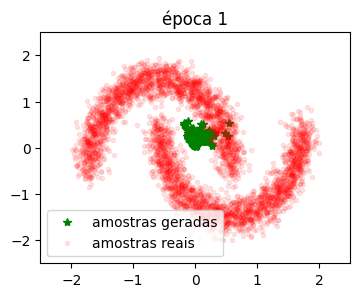

at epoch 25, G loss: 0.7932589746290638, D loss 1.3754658852854083


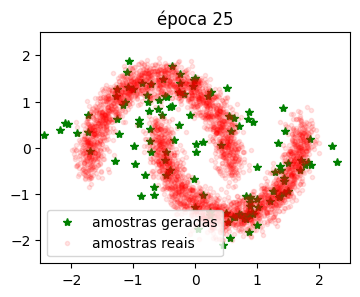

at epoch 50, G loss: 0.7778916512766192, D loss 1.3922164670882686


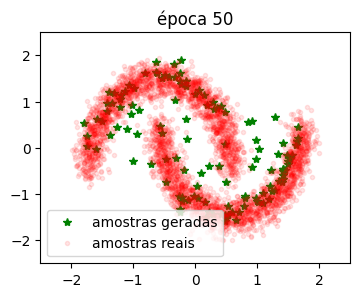

at epoch 75, G loss: 0.7478623544016192, D loss 1.4052873426868069


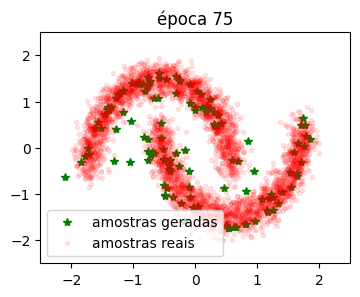

at epoch 100, G loss: 0.7399822358162172, D loss 1.4178658762285787


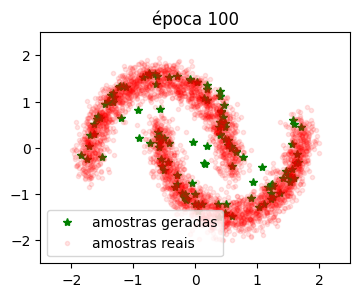

at epoch 125, G loss: 0.7495537419472972, D loss 1.426485369282384


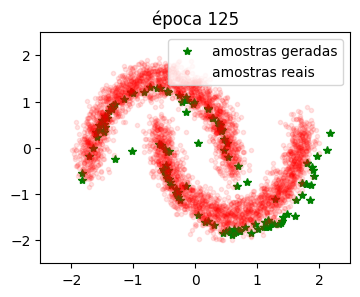

at epoch 150, G loss: 0.7107044343025454, D loss 1.4300068270775579


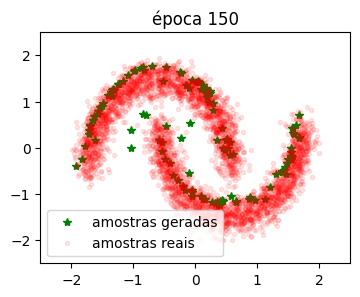

at epoch 175, G loss: 0.7127715695288873, D loss 1.4274983559885333


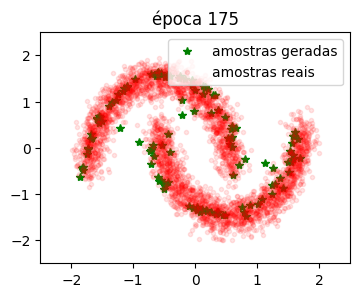

at epoch 200, G loss: 0.7195973550119708, D loss 1.4289425265404485


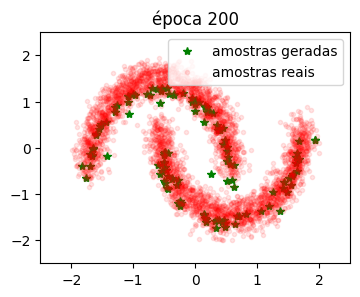

at epoch 225, G loss: 0.7150977350050404, D loss 1.4278981608729209


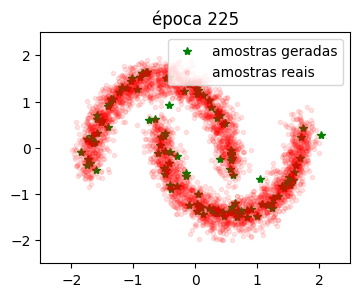

at epoch 250, G loss: 0.7132891378095073, D loss 1.4230175633584299


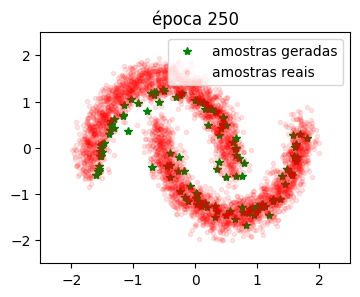

at epoch 275, G loss: 0.8075316029210244, D loss 1.4222120469616306


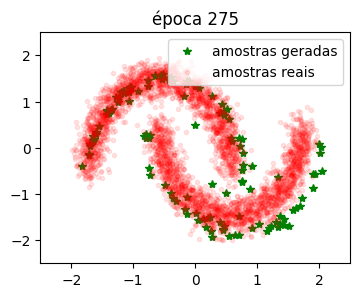

at epoch 300, G loss: 0.7820969858477193, D loss 1.4273866222750755


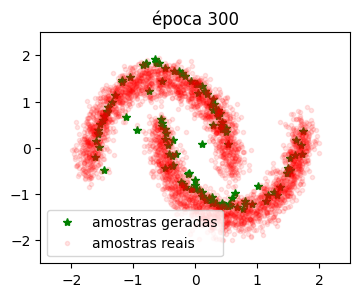

at epoch 325, G loss: 0.735335196218183, D loss 1.442687496062248


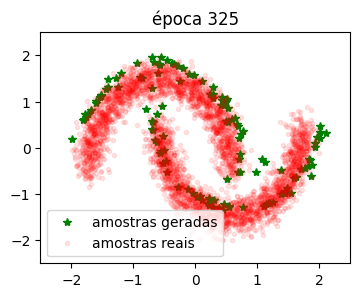

at epoch 350, G loss: 0.7211205882410849, D loss 1.4340570511356476


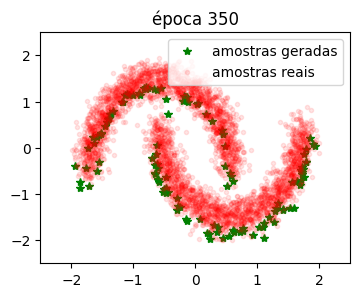

at epoch 375, G loss: 0.7216546458582724, D loss 1.4277121020901589


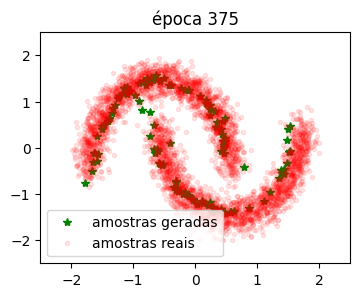

at epoch 400, G loss: 0.7258928975751323, D loss 1.4366240962859123


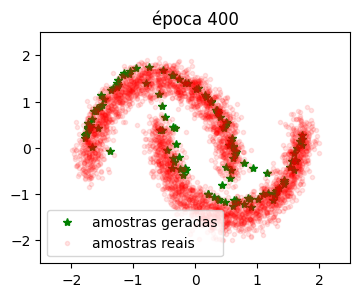

at epoch 425, G loss: 0.7099984691989037, D loss 1.4272240669496599


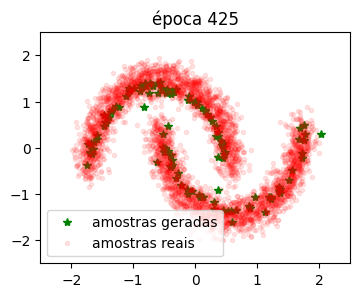

at epoch 450, G loss: 0.7034459883166898, D loss 1.4377501703077746


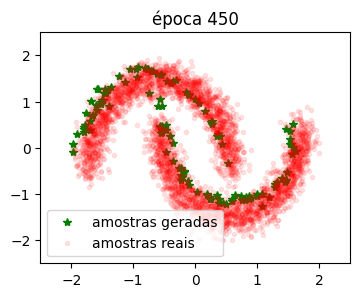

at epoch 475, G loss: 0.753037852625693, D loss 1.43261964859501


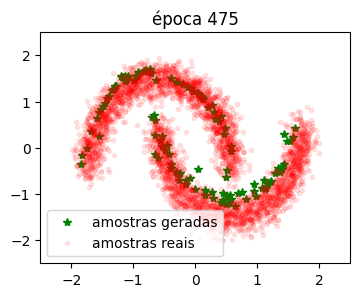

at epoch 500, G loss: 0.7029644135505922, D loss 1.4400840267058341


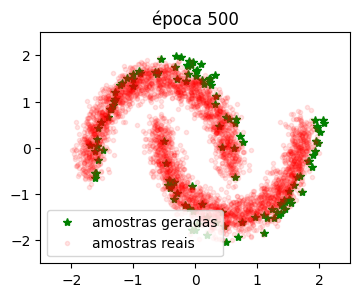

at epoch 525, G loss: 0.7271597462315713, D loss 1.4298990311161164


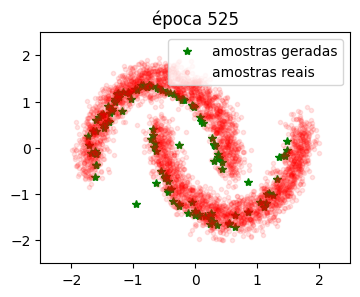

at epoch 550, G loss: 0.7121336537022744, D loss 1.4313749497936619


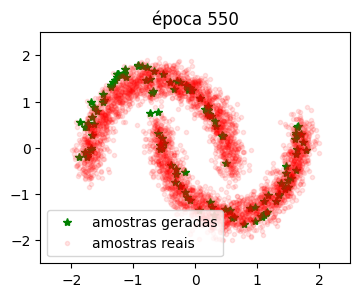

at epoch 575, G loss: 0.7148269530265562, D loss 1.4286044951408141


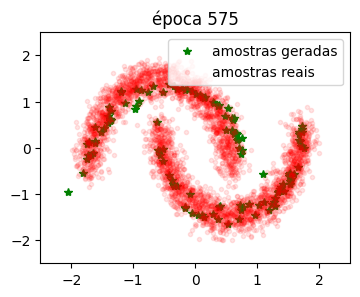

at epoch 600, G loss: 0.7165866359587638, D loss 1.429780037172379


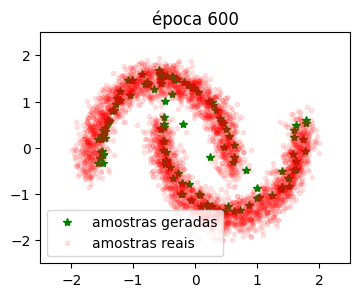

at epoch 625, G loss: 0.7125761585850869, D loss 1.4323116425544984


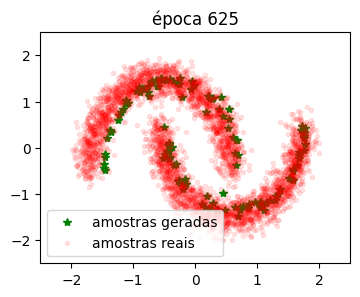

at epoch 650, G loss: 0.7157387272004159, D loss 1.429079363423009


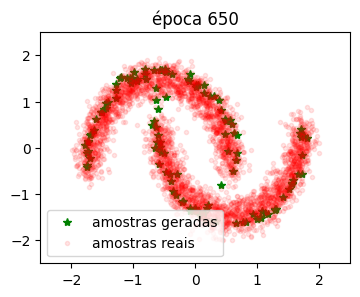

at epoch 675, G loss: 0.7142462576589277, D loss 1.4303766066028225


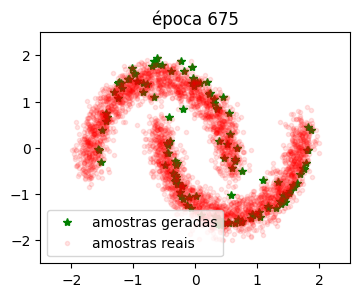

at epoch 700, G loss: 0.7089225399878717, D loss 1.4335709848711569


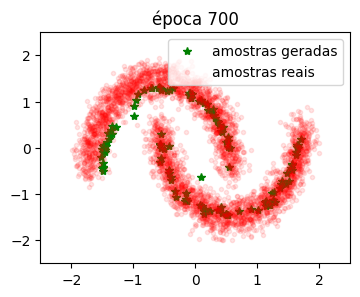

at epoch 725, G loss: 0.7494200429608745, D loss 1.4191978208480343


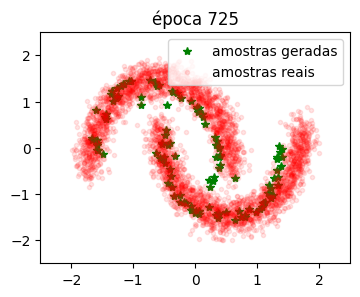

at epoch 750, G loss: 0.7040189927624118, D loss 1.436493658250378


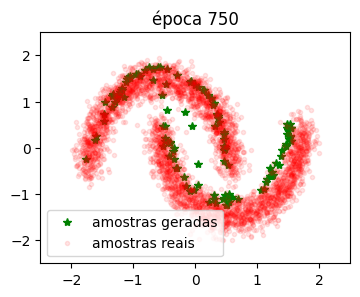

at epoch 775, G loss: 0.7172588840607674, D loss 1.4305937982374621


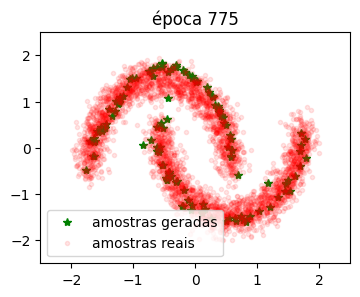

at epoch 800, G loss: 0.7264215407832977, D loss 1.4280171548166583


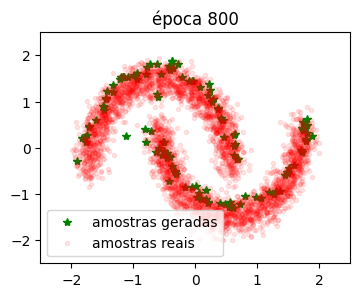

at epoch 825, G loss: 0.7104966563563193, D loss 1.4297397982689641


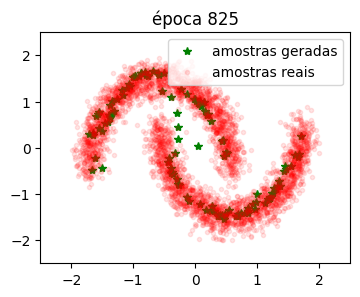

at epoch 850, G loss: 0.7200400444769091, D loss 1.4328540678947204


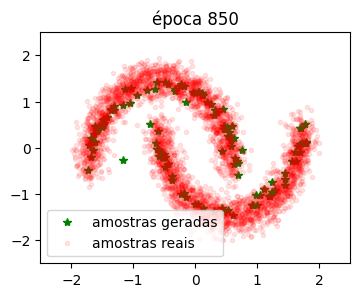

at epoch 875, G loss: 0.7110289912069997, D loss 1.4344535335417716


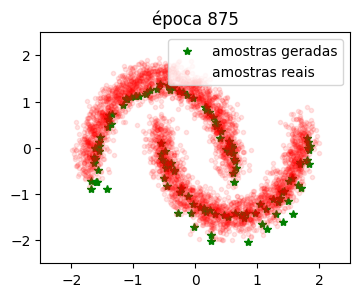

at epoch 900, G loss: 0.7114927845616494, D loss 1.4278150989163307


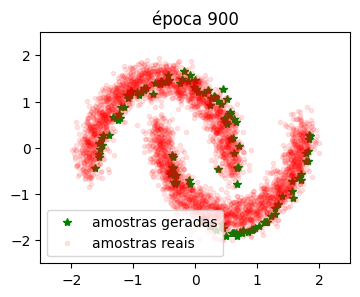

at epoch 925, G loss: 0.7322438147760206, D loss 1.4303060962307839


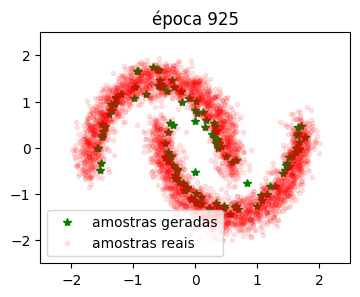

at epoch 950, G loss: 0.7235676550096081, D loss 1.4313735961914062


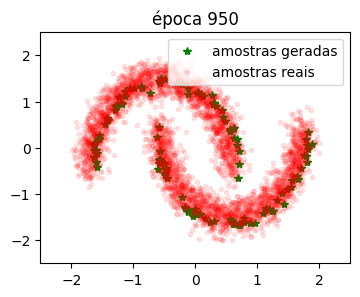

at epoch 975, G loss: 0.7162056584512034, D loss 1.4269794341056579


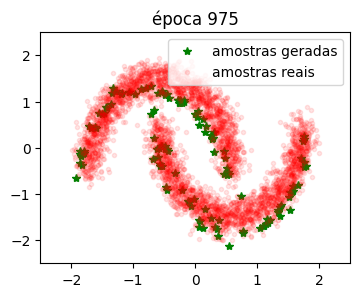

at epoch 1000, G loss: 0.7212445659022177, D loss 1.4303673774965349


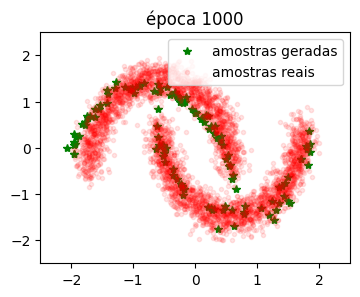

In [54]:
for epoch in range(1000):                        # Loop principal de treinamento do GAN (até 10.000 épocas no máximo).
    gloss = 0                                     # Inicializa acumulador da perda do gerador.
    dloss = 0                                     # Inicializa acumulador da perda do discriminador.

    for n, real_samples in enumerate(train_loader):   # Itera sobre os lotes do conjunto de treino.
        loss_D = train_D_on_real(real_samples)        # Treina o discriminador em amostras reais.
        dloss += loss_D                               # Acumula a perda do discriminador.
        loss_D = train_D_on_fake()                    # Treina o discriminador em amostras falsas (geradas).
        dloss += loss_D                               # Acumula novamente a perda do discriminador.
        loss_G, fake_samples = train_G()              # Treina o gerador e obtém as amostras falsas da iteração.
        gloss += loss_G                               # Acumula a perda do gerador.

    test_epoch(epoch, gloss, dloss, n, fake_samples)  # Exibe métricas e plota amostras (a cada 25 épocas ou na primeira).

## Salvar o modelo e gerar novas amostras

In [ ]:
scripted = torch.jit.script(G)                       # Converte o gerador (G) para o formato TorchScript.
scripted.save('files/twomoon.pt')                # Salva o modelo convertido no arquivo "twomoon.pt" dentro da pasta "files".

In [ ]:
new_G = torch.jit.load('files/twomoon.pt')  # Carrega o modelo salvo do arquivo "twomoon.pt".

In [57]:
noise = torch.randn((batch_size, 2)).to(device)      # Gera um lote de vetores de ruído aleatório ~ N(0,1), shape [batch_size, 2], e move para o dispositivo (CPU ou GPU).
new_data = new_G(noise)                              # Passa o ruído pelo gerador carregado (new_G): produz novas amostras falsas (x, y).


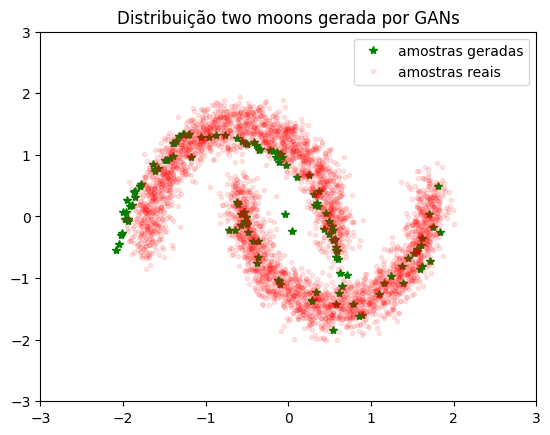

In [60]:
fig = plt.figure(dpi=100)                                       # Cria uma nova figura.

plt.plot(new_data.detach().cpu().numpy()[:,0],
         new_data.detach().cpu().numpy()[:,1], "*", c="g",
         label="amostras geradas")                              # Plota as amostras geradas em verde, usando marcador "*".

plt.plot(train_data[:,0], train_data[:,1], ".", c="r",
         alpha=0.1, label="amostras reais")                     # Plota as amostras reais em vermelho, com transparência (alpha=0.1).

plt.title("Distribuição two moons gerada por GANs")   # Define o título do gráfico.
plt.xlim(-3, 3)                                                 # Limita o eixo X ao intervalo [0,50].
plt.ylim(-3, 3)                                                 # Limita o eixo Y ao intervalo [0,50].
plt.legend()                                                    # Exibe a legenda (amostras reais vs. geradas).
plt.show()                                                      # Renderiza e exibe a figura.

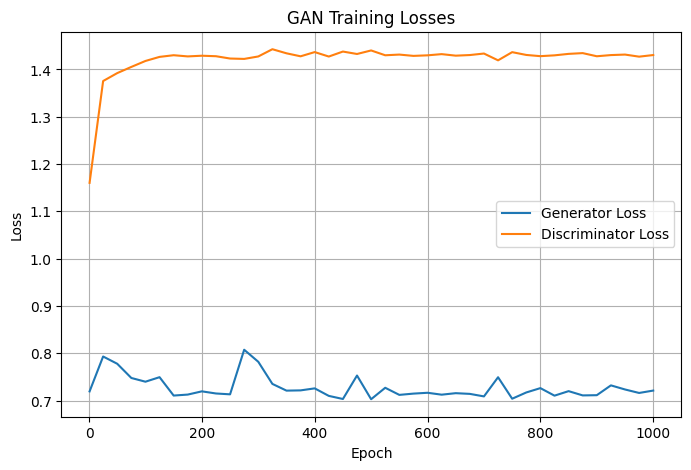

In [ ]:
import matplotlib.pyplot as plt

log = """
at epoch 1, G loss: 0.7195208764845326, D loss 1.1602937021563131
at epoch 25, G loss: 0.7932589746290638, D loss 1.3754658852854083
at epoch 50, G loss: 0.7778916512766192, D loss 1.3922164670882686
at epoch 75, G loss: 0.7478623544016192, D loss 1.4052873426868069
at epoch 100, G loss: 0.7399822358162172, D loss 1.4178658762285787
at epoch 125, G loss: 0.7495537419472972, D loss 1.426485369282384
at epoch 150, G loss: 0.7107044343025454, D loss 1.4300068270775579
at epoch 175, G loss: 0.7127715695288873, D loss 1.4274983559885333
at epoch 200, G loss: 0.7195973550119708, D loss 1.4289425265404485
at epoch 225, G loss: 0.7150977350050404, D loss 1.4278981608729209
at epoch 250, G loss: 0.7132891378095073, D loss 1.4230175633584299
at epoch 275, G loss: 0.8075316029210244, D loss 1.4222120469616306
at epoch 300, G loss: 0.7820969858477193, D loss 1.4273866222750755
at epoch 325, G loss: 0.735335196218183, D loss 1.442687496062248
at epoch 350, G loss: 0.7211205882410849, D loss 1.4340570511356476
at epoch 375, G loss: 0.7216546458582724, D loss 1.4277121020901589
at epoch 400, G loss: 0.7258928975751323, D loss 1.4366240962859123
at epoch 425, G loss: 0.7099984691989037, D loss 1.4272240669496599
at epoch 450, G loss: 0.7034459883166898, D loss 1.4377501703077746
at epoch 475, G loss: 0.753037852625693, D loss 1.43261964859501
at epoch 500, G loss: 0.7029644135505922, D loss 1.4400840267058341
at epoch 525, G loss: 0.7271597462315713, D loss 1.4298990311161164
at epoch 550, G loss: 0.7121336537022744, D loss 1.4313749497936619
at epoch 575, G loss: 0.7148269530265562, D loss 1.4286044951408141
at epoch 600, G loss: 0.7165866359587638, D loss 1.429780037172379
at epoch 625, G loss: 0.7125761585850869, D loss 1.4323116425544984
at epoch 650, G loss: 0.7157387272004159, D loss 1.429079363423009
at epoch 675, G loss: 0.7142462576589277, D loss 1.4303766066028225
at epoch 700, G loss: 0.7089225399878717, D loss 1.4335709848711569
at epoch 725, G loss: 0.7494200429608745, D loss 1.4191978208480343
at epoch 750, G loss: 0.7040189927624118, D loss 1.436493658250378
at epoch 775, G loss: 0.7172588840607674, D loss 1.4305937982374621
at epoch 800, G loss: 0.7264215407832977, D loss 1.4280171548166583
at epoch 825, G loss: 0.7104966563563193, D loss 1.4297397982689641
at epoch 850, G loss: 0.7200400444769091, D loss 1.4328540678947204
at epoch 875, G loss: 0.7110289912069997, D loss 1.4344535335417716
at epoch 900, G loss: 0.7114927845616494, D loss 1.4278150989163307
at epoch 925, G loss: 0.7322438147760206, D loss 1.4303060962307839
at epoch 950, G loss: 0.7235676550096081, D loss 1.4313735961914062
at epoch 975, G loss: 0.7162056584512034, D loss 1.4269794341056579
at epoch 1000, G loss: 0.7212445659022177, D loss 1.4303673774965349
"""

epochs = []
g_losses = []
d_losses = []

for line in log.strip().split('\n'):
    parts = line.split(',')
    epoch = int(parts[0].split()[2])
    g_loss = float(parts[1].split(':')[1])
    d_loss = float(parts[2].split()[2])
    epochs.append(epoch)
    g_losses.append(g_loss)
    d_losses.append(d_loss)

plt.figure(figsize=(8,5))
plt.plot(epochs, g_losses, label='Generator Loss')
plt.plot(epochs, d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True)
plt.show()